# Vanilla Policy Gradient

In this notebook the Vanilla Policy Gradient algorithm is implemented in TensorFlow.

### Import dependencies

In [20]:
import tensorflow.compat.v1 as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from tensorflow.python.framework import ops
tf.disable_v2_behavior()

W0822 20:45:52.838207 4453098944 deprecation.py:323] From /Users/leandro/git/reproduce-rl/env/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


### Setup policy network

In [21]:
def mlp(input_dim, output_dim, shape=[128]):
    """
    Setup multilayer perceptron policy network.
    
    args:
        input_dim: dimension of input vector
        output_dim: dimension of output vector
        shape: shape of hidden layers
    
    returns:
        x_ph: placeholder input
        r_ph: placeholder reward
        a_ph: placeholder action
        probs: probabilities output
        log_probs: log probabilities output
        train_step: training operation
    """
    
    # setup tensorflow placeholders
    x_ph = tf.placeholder(tf.float64, shape=[None]+list(input_dim), name='x_ph')
    r_ph = tf.placeholder(tf.float64, shape=[None, 1], name='r_ph')
    a_ph = tf.placeholder(tf.float64, shape=[None, output_dim], name='a_ph')
    
    # setup feedforward network
    tmp_x = x_ph
    for dim in shape:
        tmp_x = tf.layers.dense(tmp_x, dim, activation=tf.nn.relu)
    probs = tf.layers.dense(tmp_x, output_dim, activation=tf.nn.softmax, name='p_actions')
    
    # setup losses and optimizer
    log_probs = tf.log(tf.reduce_sum(tf.multiply(probs, a_ph), axis=-1), name='log_prob')
    loss = tf.multiply(log_probs, r_ph)
    loss = -tf.reshape(loss, [-1])
    train_step = tf.train.AdamOptimizer().minimize(loss)
    
    return x_ph, r_ph, a_ph, probs, log_probs, train_step

### Setup environment

In [22]:
env = gym.make('CartPole-v0')

In [23]:
env.action_space, env.action_space.n

(Discrete(2), 2)

In [24]:
env.observation_space.shape

(4,)

In [25]:
env.reset()

array([-0.04322151, -0.0316813 ,  0.04285916,  0.03108787])

### Helper function

In [1]:
def get_action(action_probs, epsilon, env, stochastic=True):
    """
    Get action from actions space. With probability 1-epsilon,
    a random action is sampled, otherwise the action_probs are
    used to get an action. If stochastic, the actions are sampled
    according to the probablities of each action, otherwise the
    action with the highest probability is returned.
    """
    
    if np.random.rand()>epsilon:
        if stochastic:
            action = np.random.choice(list(range(len(action_probs))), p=action_probs)
        else:
            action = np.argmax(action_probs)
    else:
        action = env.action_space.sample()
    return action

def calc_discounted_rewards(r,gamma=0.9):
    """
    Calculate the discounted future rewards with 
    a gamma factor.
    """
    discounted_rewards = []
    
    for i in range(len(r)):
        tmp_rewards = []
        for j in range(len(r)-i):
            tmp_rewards.append(r[i+j]*(gamma**j))
        discounted_rewards.append(np.sum(tmp_rewards))
        
    return np.array(discounted_rewards)   

### Show discounted reward example

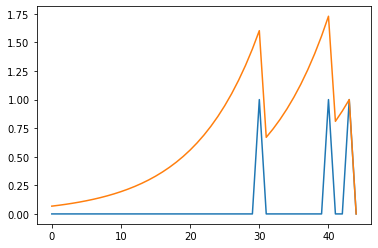

In [28]:
test_array= [0]*30+[1,0,0,0,0,0,0,0,0,0,1,0,0,1,0]

plt.plot(test_array)
plt.plot(calc_discounted_rewards(test_array))
plt.show()

### Training scheme for VPG

In [29]:
def VPG(env, n_steps=10*4, epsilon_range=[0.99, 0.1], render=False):
    """
    Vanilla Policy Gradient implementation in TensorFlow.
    
    args:
        env: OpenAI gym environment
        n_steps=10*4: number of training steps
        epsilon_range=[0.99, 0.1]: epsilon decay range
        render=False: option to render environment
        
    returns:
        observations: list of observations during training
        actions: list of observations during training
        rewards: list of observations during training
        total_rewards: list of total rewards during episode
        total_discounted_rewards: list of discounted rewards at eatch step
    """
    
    # get env information
    obs_shape = env.observation_space.shape
    action_space = env.action_space.n
    print('obs shape:',obs_shape,'| action space:', action_space)
    
    # setup tensorflow model
    ops.reset_default_graph()
    sess = tf.InteractiveSession()
    x_ph, r_ph, a_ph, probs, log_probs, train_step = mlp(obs_shape, action_space)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    # get epsilon decay
    epsilons = get_epsilons(epsilon_range, n_steps)
    
    # setup list for storage
    total_rewards = []
    total_discounted_rewards = []
    observations = []
    rewards = []
    actions = []
    
    # initialize baseline
    baseline=0
    
    # this is to reset env and get first obs
    game_done = True
    
    # rollout training
    for i in tqdm(range(n_steps)):
        if render:
            env.render()
        
        # when game is done, optimize network
        if game_done:
            if len(rewards)>0:
                
                # calculate discounted rewards and baseline
                discounted_rewards = calc_discounted_rewards(rewards, gamma=1)
                advantage = discounted_rewards-baseline
                
                # train policy network
                sess.run(train_step, feed_dict={x_ph: np.array(observations),
                                                r_ph: np.expand_dims(advantage,axis=1),
                                                a_ph: np.array(actions)})
                
                # update baseline
                baseline = np.mean(discounted_rewards)
                total_discounted_rewards += list(discounted_rewards)
                total_rewards.append(sum(rewards))
                
            obs = env.reset()
            observations = []
            rewards = []
            actions = []
            
        observations.append(obs)
        
        # get action probabilities from policy network
        action_probs = sess.run(probs, feed_dict={x_ph: np.expand_dims(obs, axis=0)})
        
        # get epsilon-greedy action
        action = get_action(np.squeeze(action_probs), epsilons[i], env)
        
        # update environment with chosen action
        obs, reward, game_done, info = env.step(action)
        
        # update lists
        rewards.append(reward)
        action_vec = np.zeros(action_space)
        action_vec[action]=1
        actions.append(action_vec)
        
    env.close()
    return observations, actions, rewards, total_rewards, total_discounted_rewards

### Run training

In [30]:
obs, actions, rewards,total_rewards, discounted_rewards = VPG(env, n_steps=100000, render=False, epsilon_range=[0,0])

/Users/leandro/git/reproduce-rl/env/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
W0822 20:46:04.030754 4453098944 deprecation.py:323] From <ipython-input-21-705f2d035888>:27: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


obs shape: (4,) | action space: 2


100%|██████████| 100000/100000 [00:36<00:00, 2738.38it/s]


### Show results

/Users/leandro/git/reproduce-rl/env/lib/python3.7/site-packages/pandas/core/window.py:1833: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


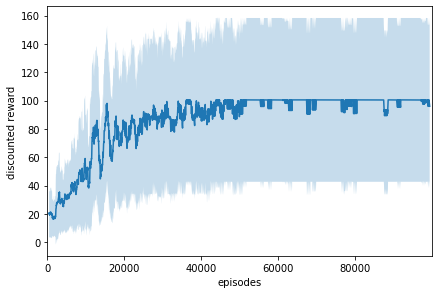

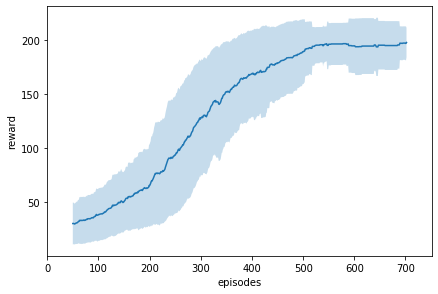

In [31]:
plot_reward(discounted_rewards, window=1000, y_label='discounted reward')
plot_reward(total_rewards, window=100)

In [32]:
import antigravity